In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 1.3 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2023-01-01', '2023-12-31')
df.tail

<bound method NDFrame.tail of              Open   High    Low  Close    Volume    Change
Date                                                      
2023-01-02  55500  56100  55200  55500  10031448  0.003617
2023-01-03  55400  56000  54500  55400  13547030 -0.001802
2023-01-04  55700  58000  55600  57800  20188071  0.043321
2023-01-05  58200  58800  57600  58200  15682826  0.006920
2023-01-06  58300  59400  57900  59000  17334989  0.013746
...           ...    ...    ...    ...       ...       ...
2023-12-21  74600  75000  74300  75000  13478766  0.002674
2023-12-22  75800  76300  75400  75900  14515608  0.012000
2023-12-26  76100  76700  75700  76600  13164909  0.009223
2023-12-27  76700  78000  76500  78000  20651042  0.018277
2023-12-28  77700  78500  77500  78500  17797536  0.006410

[245 rows x 6 columns]>

# 분석 코드

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

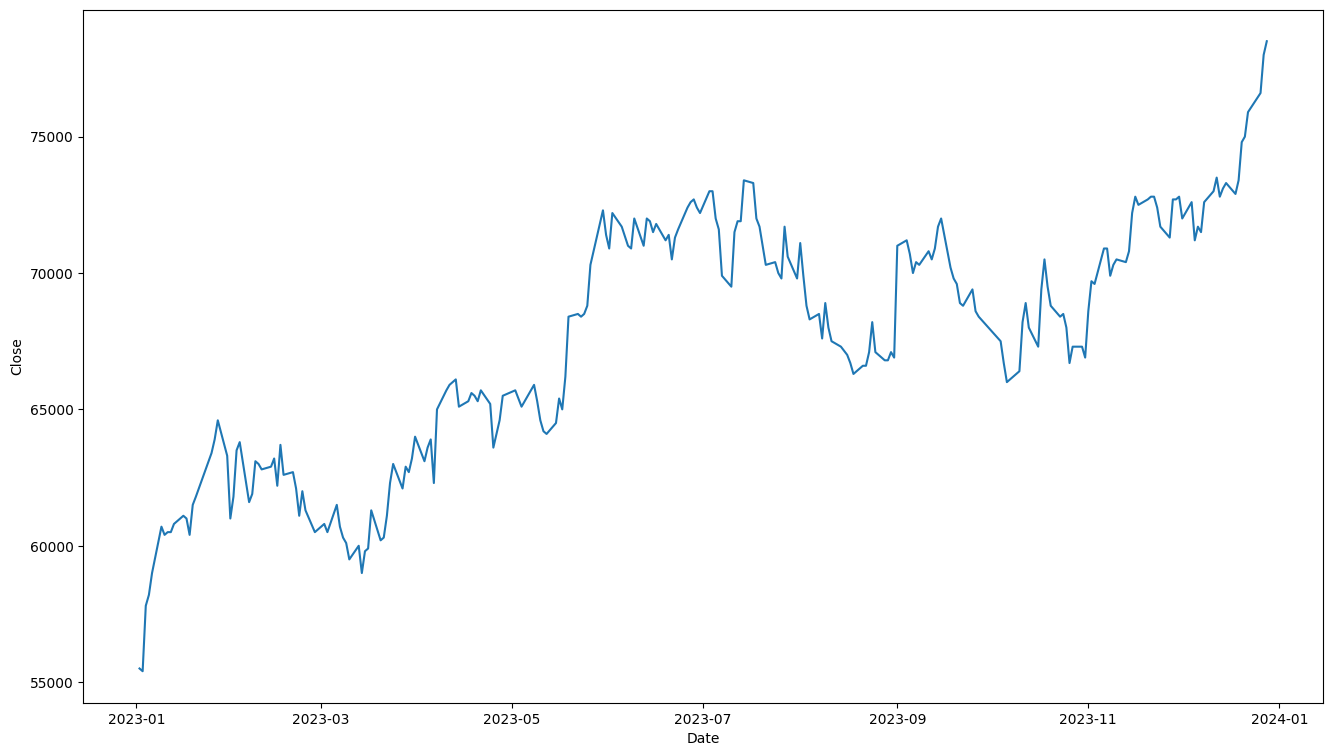

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [7]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [8]:
#넘파이 배열로 변경
#입력변수
x = df[['Open', 'High', 'Low', 'Volume']].values
#예측변수 - 종가
y = df['Close'].values

#시퀀스 데이터 생성
#시퀀스 - 모델이 학습할 때 한 번에 볼 데이터의 수
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  # 전체 데이터 크기에서 시퀀스를 뺀 만큼 반복
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 200 # 학습 데이터와 테스트 데이터를 나누는 기준 인덱스
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

# 순서대로 200개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

# [시퀀스 샘플 수, 각 시퀀스의 길이, 특성 수_입력 변수의 개수]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-8-c7d8a6d67423>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([40, 5, 4]) torch.Size([40, 1])


In [10]:
x_train_seq

tensor([[[0.0045, 0.0044, 0.0304, 0.1739],
         [0.0000, 0.0000, 0.0000, 0.3192],
         [0.0135, 0.0889, 0.0478, 0.5937],
         [0.1256, 0.1244, 0.1348, 0.4075],
         [0.1300, 0.1511, 0.1478, 0.4758]],

        [[0.0000, 0.0000, 0.0000, 0.3192],
         [0.0135, 0.0889, 0.0478, 0.5937],
         [0.1256, 0.1244, 0.1348, 0.4075],
         [0.1300, 0.1511, 0.1478, 0.4758],
         [0.1928, 0.2089, 0.2217, 0.5297]],

        [[0.0135, 0.0889, 0.0478, 0.5937],
         [0.1256, 0.1244, 0.1348, 0.4075],
         [0.1300, 0.1511, 0.1478, 0.4758],
         [0.1928, 0.2089, 0.2217, 0.5297],
         [0.2152, 0.2267, 0.2348, 0.3735]],

        ...,

        [[0.5964, 0.5822, 0.5957, 0.2398],
         [0.5964, 0.5689, 0.5739, 0.2880],
         [0.6009, 0.5689, 0.5826, 0.1978],
         [0.5202, 0.5289, 0.5304, 0.4007],
         [0.5247, 0.5022, 0.5304, 0.2278]],

        [[0.5964, 0.5689, 0.5739, 0.2880],
         [0.6009, 0.5689, 0.5826, 0.1978],
         [0.5202, 0.5289, 0.5304

In [11]:
# 학습 데이터
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
# 테스트 데이터
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

# 배치 크기
batch_size = 5
# 데이터를 배치 단위로 나누고 셔플링
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

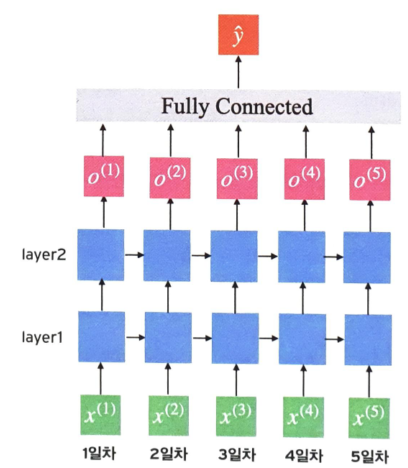

In [12]:
# 기본 하이퍼 파라미터 설정
# 입력 데이터 텐서의 세 번째 차원(특성 수)의 크기 반환
input_size = x_seq.size(2)
# 순환 레이어의 수
num_layers = 2
# 각 레이어의 뉴런 수
hidden_size = 8

In [13]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    # 부모 클래스(nn.Module) 생성자 호출
    super(VanillaRNN, self).__init__()
    # 디바이스 설정
    self.device = device
    # 각 레이어의 뉴런 수 지정
    self.hidden_size = hidden_size
    # 순환 레이어의 수 지정
    self.num_layers = num_layers
    # rnn 모델 정의
    # batch_first = 입력 텐서의 첫 번째 차원을 배치 크기로 지정
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    # RNN 층에서 나온 결과를 fc (fully-connected) 층으로 전달해서 예측값 계산
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  # 순전파
  def forward(self, x):
    # hidden 상태 초기값을 0으로 설정
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    # rnn 모델을 사용해 입력 데이터를 처리한 뒤 출력과 최종 hidden 상태 반환
    out,_ = self.rnn(x, h0)
    # 출력 텐서 형태 변환 (배치 크기, 나머지 차원)
    out = out.reshape(out.shape[0], -1)
    # fc층을 통해 최종 출력 계산
    out = self.fc(out)
    return out

In [14]:
# 모델 인스턴스 생성
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [15]:
# 손실함수 - MSE
criterion = nn.MSELoss()
# 학습 횟수
num_epochs = 50
# 최적화 알고리즘 - Adam
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [16]:
# 학습 횟수별 손실을 저장할 리스트
loss_graph = []
# 학습 데이터 배치의 수
n = len(train_loader)

for epoch in range(num_epochs):
  # 학습 횟수별 누적 손실을 저장할 변수 초기화
  running_loss = 0

  # 학습 데이터 배치 단위로 처리
  for data in train_loader:
    # 입력 시퀀스, 예측 변수
    seq, target = data
    # 출력값 계산
    out = model(seq)
    # 손실함수 계산
    loss = criterion(out, target)

    # gradient 초기화
    optimizer.zero_grad()
    # 손실함수를 기준으로 역전파
    loss.backward()
    # 최적화
    optimizer.step()
    # 현재 배치의 손실을 누적 손실에 추가
    running_loss += loss.item()

  # 평균 손실값 출력 (학습 횟수가 증가함에 따라 손실 감소)
  loss_graph.append(running_loss/n)
  # 학습 횟수 10마다 출력
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0282
[epoch : 10] loss: 0.0038
[epoch : 20] loss: 0.0031
[epoch : 30] loss: 0.0025
[epoch : 40] loss: 0.0023


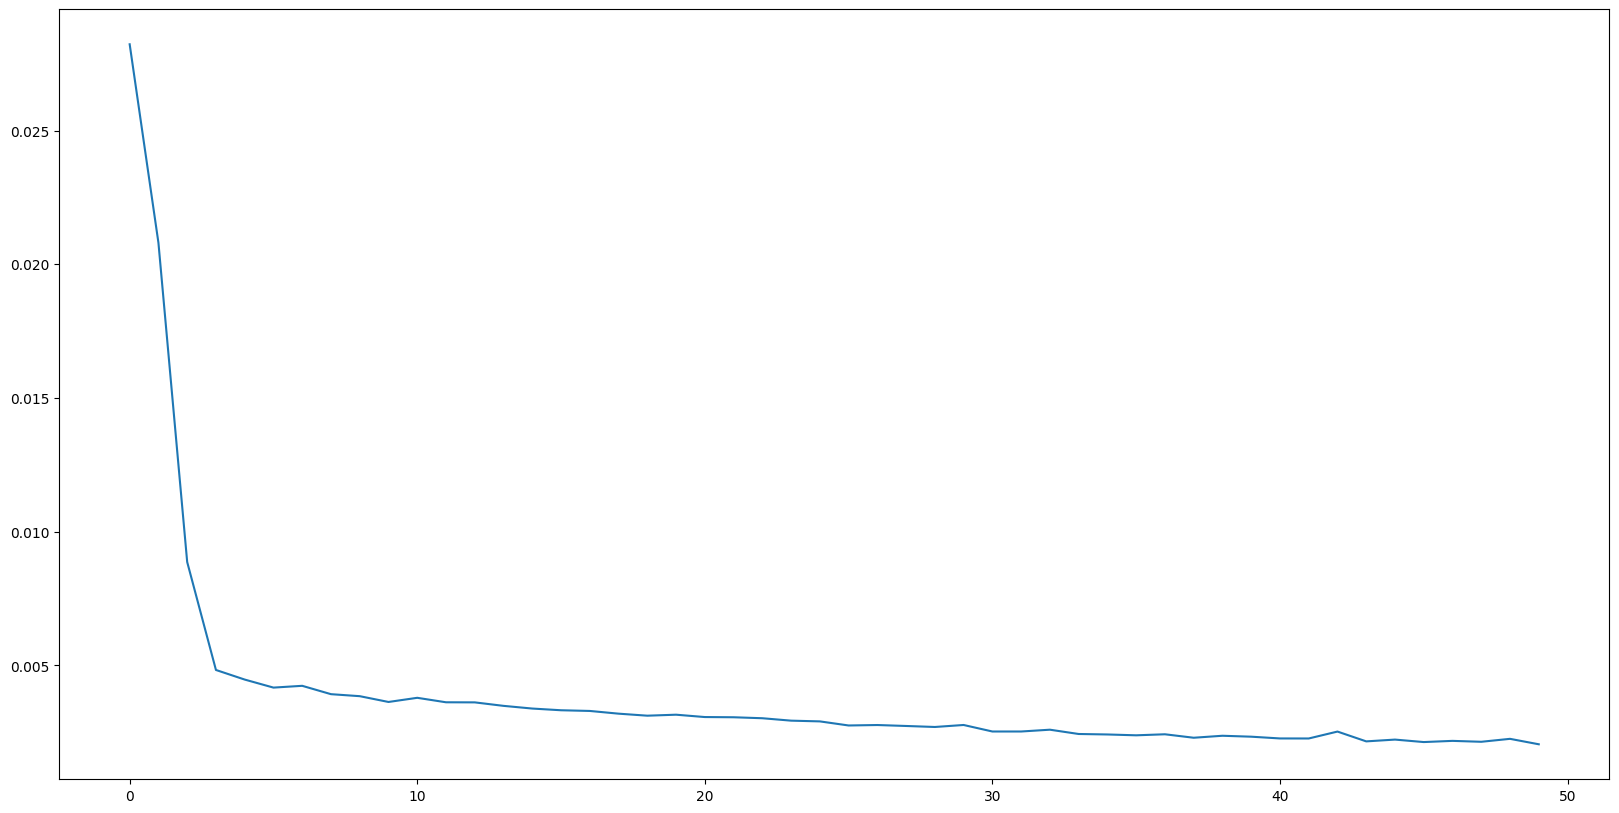

In [17]:
# 그래프 출력
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [18]:
# 학습 데이터, 테스트 데이터 결합
concatdata = torch.utils.data.ConcatDataset([train, test])
# 데이터 로더 초기화
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

# graident 계산 비활성화
with torch.no_grad():
  # 예측 결과를 저장할 리스트
  pred = []
  # 모델을 평가모드로 설정
  model.eval()
  # 데이터를 배치 단위로 처리
  for data in data_loader:
    # 입력 시퀀스, 예측 변수
    seq, target = data
    # 출력값 계산
    out = model(seq)
    # 출력값을 예측 결과로 저장
    pred += out.cpu().tolist()

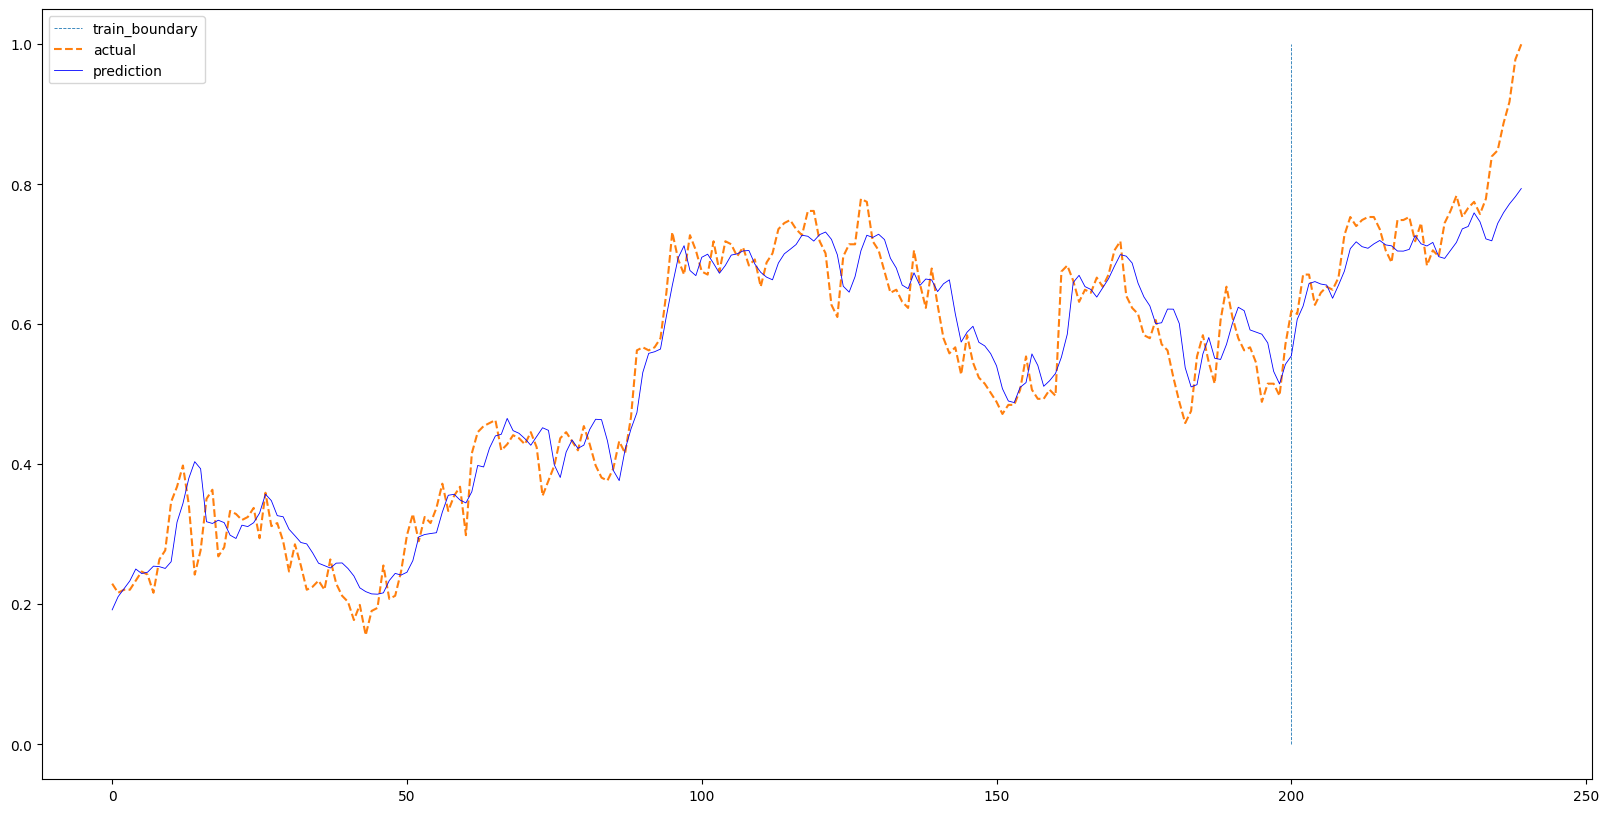

In [19]:
# 그래프 출력
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [20]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [21]:
# LSTM 모델 정의 (RNN과 유사)
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    # fc층 정의 (LSTM 출력을 1차원 출력으로 변환)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  # 순전파 (RNN과 유사)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    # 셀 초기값을 0으로 설정
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [22]:
# 모델 인스턴스 생성
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [23]:
# 손실 함수
criterion = nn.MSELoss()
# 학습 횟수
num_epochs =50
# 최적화
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
# 손실 계산 (RNN과 유사)
# 학습횟수 30이상부터는 손실이 완만하게 감소하며 비슷한 수준으로 유지
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0528
[epoch: 10] loss: 0.0043
[epoch: 20] loss: 0.0037
[epoch: 30] loss: 0.0031
[epoch: 40] loss: 0.0030


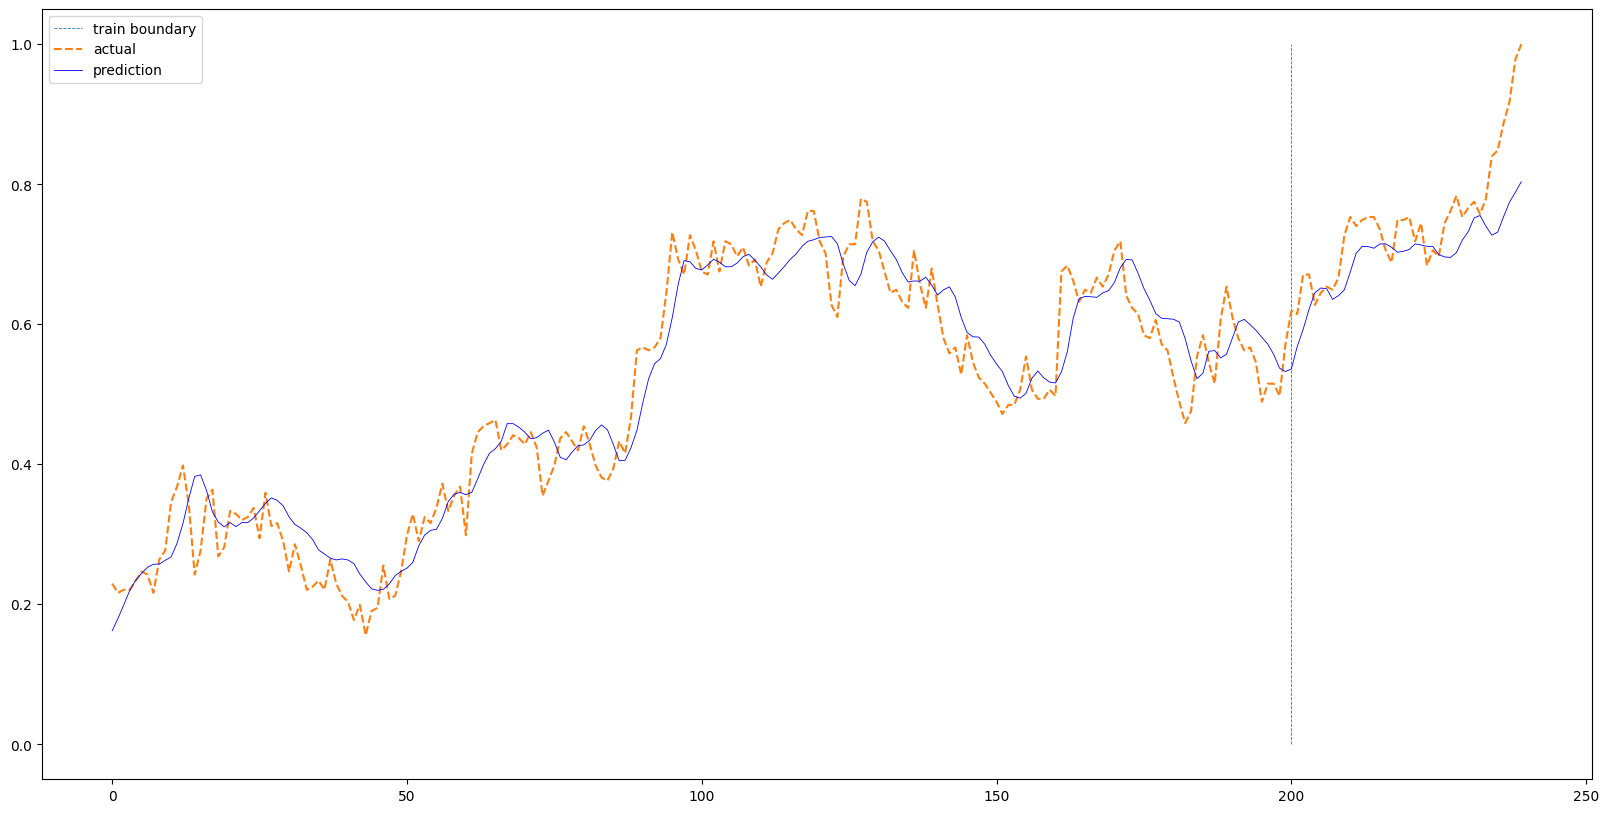

In [25]:
# 학습 데이터와 테스트 데이터를 결합한 뒤 손실 그래프 출력
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [ ]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2023-01-01', '2024-12-31')
df.tail